In [28]:
import torch                          # Le cœur de PyTorch : tensors, calculs, GPU
import torch.nn as nn                 # Contient toutes les couches du réseau (Conv2D, Linear, etc.)
import torch.optim as optim           # Optimiseurs pour entraîner le modèle (Adam, SGD, etc.)
from torch.utils.data import DataLoader  # Pour gérer le batching et le shuffle des datasets
from torch.utils.data import random_split
from torchvision import datasets, transforms, models  # Outils pour datasets, transformations et modèles pré-entraînés


import numpy as np                    # Manipulation de tableaux, conversion images → tensors
import pandas as pd                   # Pour lire et écrire le fichier test_template.csv
import os                             # Gestion des fichiers et dossiers

# -----------------------------
# Librairies pour la visualisation
# -----------------------------
import matplotlib.pyplot as plt       # Visualiser les images et tracer des courbes

# -----------------------------
# Librairies pour la vision par ordinateur
# -----------------------------
import cv2                            # Capturer la webcam et détecter les visages
from PIL import Image 
from skimage import io
import matplotlib.pyplot as plt
import os, random

Text(0.5, 1.0, 'neutral')

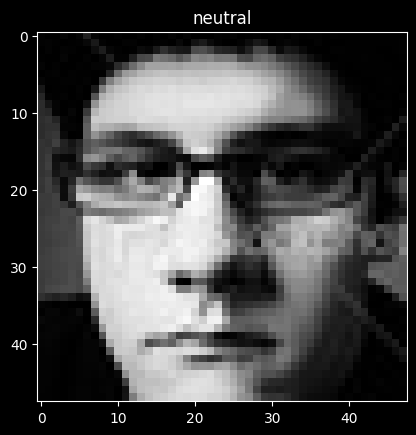

In [29]:
#observations des images
emotions = ['neutral', 'angry', 'fear', 'happy', 'sad', 'surprise', 'disgust']
emotion = 'neutral'
x = random.randint(0, 6)
path = f'data/dataTrain/train/{emotion}/'
img = io.imread(os.path.join(path, random.choice(os.listdir(path))))
plt.imshow(img, cmap='gray')
plt.title(emotion)
# plt.show()

In [30]:
import os

for emotion in os.listdir('data/dataTrain/train'):
    print(emotion, ":", len(os.listdir(os.path.join('data/dataTrain/train', emotion))))


angry : 3995
disgust : 436
fear : 4097
happy : 7215
neutral : 4965
sad : 4830
surprise : 3171


In [31]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels = 3), # images en niveaux de gris rgb
    transforms.Resize((224, 224)),

# data augmentation. eviter apprendre par coeur (chaque epoch change les images pour paraitre différement pour le modele)
    transforms.RandomHorizontalFlip(),           # augmentation horizontale
    transforms.ColorJitter(brightness=0.2, contrast=0.2),

    transforms.ToTensor(),             # convertit en tenseur [0,1]
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)) # normalise entre des range que imagenet comprend bien
])
eval_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels = 3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])


In [32]:
#80% des données d'entrainement pour l'entrainement et 20% pour validation
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset

train_root = "data/dataTrain/train"

# dataset "base" juste pour récupérer les labels (targets)
base_ds = datasets.ImageFolder(train_root, transform=None)
y = base_ds.targets  # liste d'entiers 0..6

# séparation équilibré entre train et val
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(X=[0]*len(y), y=y))

# datasets avec les bons transforms
train_full = datasets.ImageFolder(train_root, transform=train_transform)
val_full   = datasets.ImageFolder(train_root, transform=eval_transform)

train_dataset = Subset(train_full, train_idx)
val_dataset   = Subset(val_full, val_idx)

print("Train size:", len(train_dataset), "Val size:", len(val_dataset))

22967 5742


In [ ]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# compter les classes dans le train split
train_targets = [y[i] for i in train_idx]  # labels du train

#compte le nombre d'images par class
class_counts = torch.bincount(torch.tensor(train_targets))
class_weights = 1.0 / class_counts.float() #attribut une proba a chaque class

# poids par exemple (chaque image reçoit le poids de sa classe)
sample_weights = torch.tensor([class_weights[t] for t in train_targets], dtype=torch.float)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True #autorise de réutiliser des images
)

train_loader = DataLoader(train_dataset, batch_size=128, sampler=sampler, num_workers=2, pin_memory=True)
validation_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_data, batch_size=128, shuffle=False)

In [33]:
# --- Modèle : ResNet18 fine-tuning ---
modeleEmotions = models.resnet18(pretrained=True)

# Dé-geler uniquement le dernier bloc convolutionnel + fc
for name, param in modeleEmotions.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

nbEmotions = 7
modeleEmotions.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(512, nbEmotions)
)


print(modeleEmotions) # Modèle de classification des émotions


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

C:\Users\kamta\PycharmProjects\PythonProject\HackatonCodeML\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kamta\PycharmProjects\PythonProject\HackatonCodeML\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
#loss function on ne veut pas geler toutes les couches. Sinon, le modele s'ameliore trop lentement
def get_device():
    # NVIDIA GPU (Windows/Linux, parfois Mac via eGPU mais rare)
    if torch.cuda.is_available():
        return torch.device("cuda")
    # Apple Silicon (Mac M1/M2/M3)
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    # Fallback
    return torch.device("cpu")
print(torch.__version__)
device = get_device()
print("Using device:", device)
modeleEmotions = modeleEmotions.to(device)

# --- Optimiseur et scheduler ---
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, modeleEmotions.parameters()),
    lr=1e-4
)

# Scheduler qui réduit le learning rate. eviter stagnation
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',          # surveille la val_loss
    factor=0.5,          # réduit LR de moitié
    patience=1,          # attend 1 epoch avant de réduire
)

criterion = nn.CrossEntropyLoss()

2.5.1+cu121
Using device: cuda


In [35]:
#sanity check
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)

outputs = modeleEmotions(images)
print("outputs shape:", outputs.shape)
print("labels shape:", labels.shape)
print("labels dtype:", labels.dtype)
print("labels min/max:", labels.min().item(), labels.max().item())  # doit être 0..6

outputs shape: torch.Size([128, 7])
labels shape: torch.Size([128])
labels dtype: torch.int64
labels min/max: 0 6


In [36]:
num_epochs = 20 # 20 epoch de base pour chaque modification

#fonction principace d'entraiment et de validation
def run_one_epoch(model, loader, training: bool):
    if training:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    with torch.set_grad_enabled(training):
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            if training:
                optimizer.zero_grad()

            outputs = model(images)              # (batch, nbEmotions)
            loss = criterion(outputs, labels)

            if training:
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total


# --- Boucle principale ---
for epoch in range(num_epochs):
    train_loss, train_acc = run_one_epoch(modeleEmotions, train_loader, training=True)
    val_loss, val_acc = run_one_epoch(modeleEmotions, validation_loader, training=False)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"Val loss {val_loss:.4f} acc {val_acc:.4f}")



Epoch 1/20 | Train loss 1.4476 acc 0.4527 | Val loss 1.1618 acc 0.5618
Epoch 2/20 | Train loss 1.1300 acc 0.5763 | Val loss 1.0817 acc 0.5928
Epoch 3/20 | Train loss 0.9980 acc 0.6298 | Val loss 1.0751 acc 0.6055
Epoch 4/20 | Train loss 0.8702 acc 0.6807 | Val loss 1.0659 acc 0.6127
Epoch 5/20 | Train loss 0.7525 acc 0.7254 | Val loss 1.0856 acc 0.6115
Epoch 6/20 | Train loss 0.6311 acc 0.7752 | Val loss 1.1272 acc 0.6163
Epoch 7/20 | Train loss 0.5245 acc 0.8152 | Val loss 1.1313 acc 0.6127
Epoch 8/20 | Train loss 0.4169 acc 0.8593 | Val loss 1.2375 acc 0.6183
Epoch 9/20 | Train loss 0.3297 acc 0.8915 | Val loss 1.2825 acc 0.6115
Epoch 10/20 | Train loss 0.2731 acc 0.9104 | Val loss 1.3261 acc 0.6129
Epoch 11/20 | Train loss 0.2177 acc 0.9310 | Val loss 1.3157 acc 0.6200
Epoch 12/20 | Train loss 0.1771 acc 0.9454 | Val loss 1.4174 acc 0.6170
Epoch 13/20 | Train loss 0.1516 acc 0.9532 | Val loss 1.4685 acc 0.6092
Epoch 14/20 | Train loss 0.1268 acc 0.9624 | Val loss 1.5119 acc 0.6104
E